# Automatic emittance measurement at LCLS
In this case we have 4 quadrupoles, 3 that are used to minimize the incoming beam and
 the fourth to perform the quad scan measurement.

In [1]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../../")

import xopt
print(xopt.__version__)

# set up data saving locations
data_dir = "/home/physics3/ml_tuning/20230729_LCLS_Injector"


2.0a1+47.g1d5b3d1


In [2]:
from scripts.evaluate_function.screen_image import measure_beamsize, measure_background
from scripts.optimize_function import optimize_function
from scripts.characterize_emittance import characterize_emittance

In [3]:
## import variable ranges
import pandas as pd
filename = "../../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')
SCREEN_NAME = "OTRS:IN20:621" # OTR 3

## (Optional) Measure background image

In [4]:
MEASURE_BACKGROUND = False
BACKGROUND_FILE = f"{data_dir}/{SCREEN_NAME}_background.npy".replace(":","_")

if MEASURE_BACKGROUND:
    measure_background(SCREEN_NAME, filename=BACKGROUND_FILE)


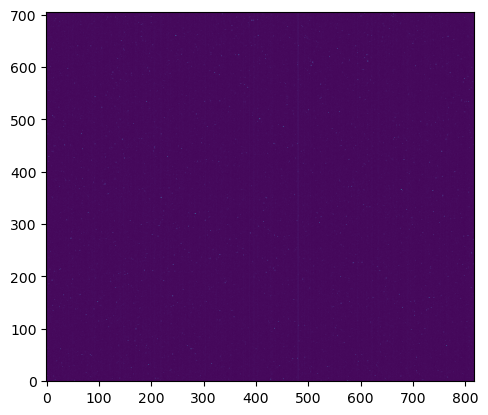

In [5]:
# verify background image
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.load(BACKGROUND_FILE),origin="lower")

## reset point

In [6]:
# get reset point
from epics import caget_many
reset_dict = dict(zip(list(VARIABLE_RANGES),caget_many(list(VARIABLE_RANGES))))
reset_dict

{'SOLN:IN20:121:BCTRL': 0.4762021,
 'QUAD:IN20:121:BCTRL': 0.0078884391,
 'QUAD:IN20:122:BCTRL': -0.0019310605,
 'QUAD:IN20:361:BCTRL': -2.6188653,
 'QUAD:IN20:371:BCTRL': 2.1427768,
 'QUAD:IN20:425:BCTRL': 1.389419316414425,
 'QUAD:IN20:441:BCTRL': 1.702166533020598,
 'QUAD:IN20:511:BCTRL': 2.9676402330162555,
 'QUAD:IN20:525:BCTRL': 0.0}

## Test screen measurement

{'screen': 'OTRS:IN20:621', 'visualize': True, 'background': '/home/physics3/ml_tuning/20230729_LCLS_Injector/OTRS_IN20_621_background.npy', 'threshold': 2}


{'Cx': 389.2625507911414,
 'Cy': 377.29307463785517,
 'Sx': 1045.8576235633834,
 'Sy': 1317.9872657047335,
 'bb_penalty': -28.626260187138826,
 'total_intensity': 19328.16846473622,
 'log10_total_intensity': 4.286190702277673,
 'resolution': 12.12,
 'time': 1690647702.352133}

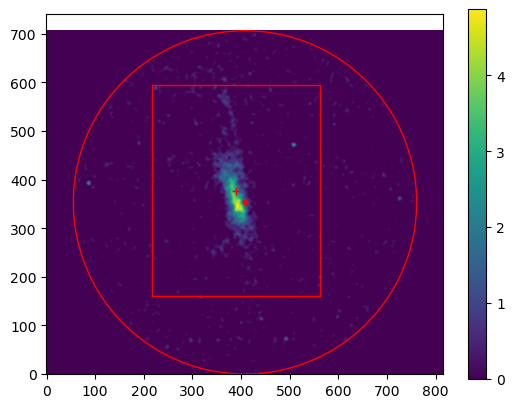

In [7]:
res = measure_beamsize({"screen":SCREEN_NAME, "visualize": True, "background":BACKGROUND_FILE, "threshold": 2})
res

## Define measurement parameters

In [8]:
from xopt import VOCS
import numpy as np
import json


TUNING_VARIABLES = ["QUAD:IN20:425:BCTRL","QUAD:IN20:441:BCTRL","QUAD:IN20:511:BCTRL"]
SCAN_VARIABLE = "QUAD:IN20:525:BCTRL"
QUAD_LENGTH = 0.108 # m
DRIFT_LENGTH = 4.17 # m
BEAM_ENERGY = 0.135 # GeV
PV_TO_INTEGRATED_GRADIENT = 1.0 # kG
ROI = None
THRESHOLD = 2.4

#with open("../../secondary_variables.json", "r") as f:
#    secondary_observables = json.loads(f)

measurement_options = {
    "screen": SCREEN_NAME,
    "background": BACKGROUND_FILE,
    "threshold": THRESHOLD,
    "roi": ROI,
    "bb_half_width": 2.0, # half width of the bounding box in terms of std
    "visualize": True,
    "save_img_location": data_dir,
    "sleep_time": 3.0
}

image_constraints = {
    "bb_penalty": ["LESS_THAN", 0.0],
    "log10_total_intensity": ["GREATER_THAN", 4]
}

# define function to measure the total size on OTR4
def eval_beamsize(input_dict):
    results = measure_beamsize(input_dict)

    # get secondary PV settings/readbacks
    #secondary_results = caget_many(secondary_observables)
    #results = results | secondary_results


    results["S_x_mm"] = results["Sx"] * 1e-3
    results["S_y_mm"] = results["Sy"] * 1e-3

    #add total beam size
    results["total_size"] = np.sqrt(results["Sx"]**2 + results["Sy"]**2)
    return results



## Optimize upstream beam parameters to minimze beamsize
Note that the scan variable is fixed at zero for maximum range quadrupole scan.

In [9]:
opt_vocs = VOCS(
        variables = {ele: VARIABLE_RANGES[ele] for ele in TUNING_VARIABLES},
        constants = {SCAN_VARIABLE: 0.0} | measurement_options,
        constraints = image_constraints,
        objectives = {"total_size": "MINIMIZE"}
    )
opt_vocs.dict()


{'variables': {'QUAD:IN20:425:BCTRL': [-2.387, 2.0],
  'QUAD:IN20:441:BCTRL': [-2.0, 2.0],
  'QUAD:IN20:511:BCTRL': [-3.0, 3.124]},
 'constraints': {'bb_penalty': ['LESS_THAN', 0.0],
  'log10_total_intensity': ['GREATER_THAN', 4.0]},
 'objectives': {'total_size': 'MINIMIZE'},
 'constants': {'QUAD:IN20:525:BCTRL': 0.0,
  'screen': 'OTRS:IN20:621',
  'background': '/home/physics3/ml_tuning/20230729_LCLS_Injector/OTRS_IN20_621_background.npy',
  'threshold': 2.4,
  'roi': None,
  'bb_half_width': 2.0,
  'visualize': True,
  'save_img_location': '/home/physics3/ml_tuning/20230729_LCLS_Injector',
  'sleep_time': 3.0},
 'observables': []}

In [10]:
reset_vals = pd.DataFrame(reset_dict | opt_vocs.constants, index=[0])
reset_vals

,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,screen,background,threshold,roi,bb_half_width,visualize,save_img_location,sleep_time
0,0.476202,0.007888,-0.001931,-2.618865,2.142777,1.389419,1.702167,2.96764,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,2.4,None,2.0,True,/home/physics3/ml_tuning/20230729_LCLS_Injector,3.0


{'QUAD:IN20:425:BCTRL': 1.938403037334178, 'QUAD:IN20:441:BCTRL': 0.8316520419670654, 'QUAD:IN20:511:BCTRL': -1.519201516352189, 'QUAD:IN20:525:BCTRL': 0.0, 'screen': 'OTRS:IN20:621', 'background': '/home/physics3/ml_tuning/20230729_LCLS_Injector/OTRS_IN20_621_background.npy', 'threshold': 2.4, 'roi': None, 'bb_half_width': 2.0, 'visualize': True, 'save_img_location': '/home/physics3/ml_tuning/20230729_LCLS_Injector', 'sleep_time': 3.0}
CAPUT QUAD:IN20:425:BCTRL 1.938403037334178
CAPUT QUAD:IN20:441:BCTRL 0.8316520419670654
CAPUT QUAD:IN20:511:BCTRL -1.519201516352189
CAPUT QUAD:IN20:525:BCTRL 0.0
{'QUAD:IN20:425:BCTRL': 1.0522847362145855, 'QUAD:IN20:441:BCTRL': -1.9125439450767385, 'QUAD:IN20:511:BCTRL': -0.5350779687334255, 'QUAD:IN20:525:BCTRL': 0.0, 'screen': 'OTRS:IN20:621', 'background': '/home/physics3/ml_tuning/20230729_LCLS_Injector/OTRS_IN20_621_background.npy', 'threshold': 2.4, 'roi': None, 'bb_half_width': 2.0, 'visualize': True, 'save_img_location': '/home/physics3/ml_tu

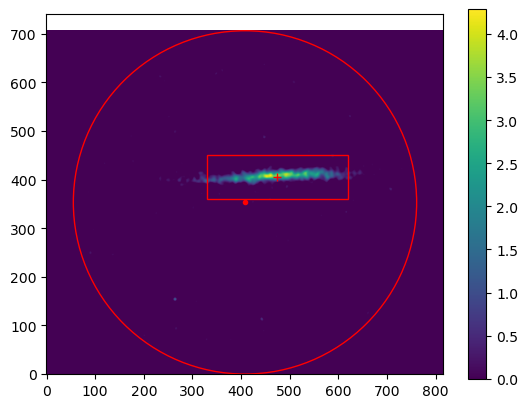

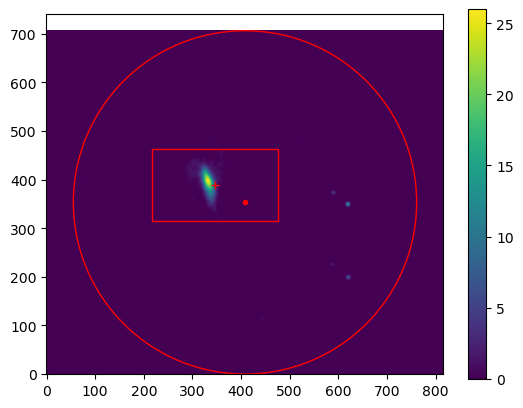

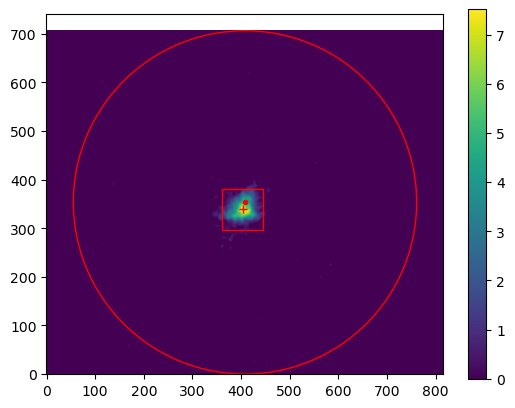

Error in callback <function flush_figures at 0x7f8f688b45e0> (for post_execute):


KeyboardInterrupt: 

In [11]:
opt_x = optimize_function(
    opt_vocs, eval_beamsize, n_iterations=5, n_initial=5
)

In [12]:
opt_x.data

,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,screen,background,threshold,roi,bb_half_width,visualize,...,bb_penalty,total_intensity,log10_total_intensity,resolution,time,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,1.938403,0.831652,-1.519202,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,2.4,None,2.0,True,...,-81.987432,10036.079700,4.001564,12.12,1.690648e+09,880397.024149,269440.058351,920.704548,3.353912,False
2,1.052285,-1.912544,-0.535078,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,2.4,None,2.0,True,...,-188.730013,25046.249604,4.398743,12.12,1.690648e+09,785004.721230,444613.175209,902.171429,3.294666,False
3,-0.625251,0.171739,2.118354,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,2.4,None,2.0,True,...,-207.826115,14095.389359,4.149077,12.12,1.690648e+09,256629.048113,255057.583372,361.818793,3.297256,False
4,-1.522318,-0.632025,-1.213707,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,2.4,None,2.0,True,...,-187.084446,5191.427551,3.715287,12.12,1.690648e+09,690834.956499,411166.148842,803.934412,3.288027,False
5,-0.446002,-0.655248,2.775384,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,2.4,None,2.0,True,...,-74.120569,9328.296404,3.969802,12.12,1.690648e+09,374552.608963,930972.598107,1003.493715,3.327956,False
6,-0.662846,0.468255,2.038440,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,2.4,None,2.0,True,...,-193.089582,13426.809872,4.127973,12.12,1.690648e+09,276637.763539,316575.247047,420.414485,3.330187,False
7,-0.702784,0.198526,1.488818,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,2.4,None,2.0,True,...,-215.640362,17228.676828,4.236252,12.12,1.690648e+09,212835.361043,252233.913507,330.031571,3.596852,False
8,-1.165959,0.220158,1.533076,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,2.4,None,2.0,True,...,-202.101174,17880.112837,4.252370,12.12,1.690648e+09,215175.552668,314681.242756,381.214904,3.356407,False
9,-0.178344,0.235059,1.170864,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,2.4,None,2.0,True,...,-192.012974,19119.312454,4.281472,12.12,1.690648e+09,424610.003358,263611.701116,499.784738,3.370111,False
10,-0.815530,0.248509,1.642336,0.0,OTRS:IN20:621,/home/physics3/ml_tuning/20230729_LCLS_Injecto...,2.4,None,2.0,True,...,-200.441371,15478.156154,4.189719,12.12,1.690648e+09,273292.415358,297098.464102,403.678389,3.367121,False


## Reset

## Automatic quad scan and emittance characterization

In [ ]:
from emitopt.utils import get_quad_strength_conversion_factor
emit_vocs = VOCS(
        variables = {SCAN_VARIABLE: VARIABLE_RANGES[SCAN_VARIABLE]},
        observables = ["S_x_mm", "S_y_mm"],
        constraints = image_constraints,
        constants = opt_x.data.iloc[-1][TUNING_VARIABLES].to_dict() | measurement_options
    )

# create conversion factor from PV value to geometric focusing strength
integrated_gradient_to_geometric_focusing_strength = get_quad_strength_conversion_factor(
        BEAM_ENERGY, QUAD_LENGTH
    )
quad_strength_scale_factor =  PV_TO_INTEGRATED_GRADIENT * integrated_gradient_to_geometric_focusing_strength

emit_results, emit_Xopt = characterize_emittance(
    emit_vocs,
    eval_beamsize,
    QUAD_LENGTH,
    DRIFT_LENGTH,
    quad_strength_key=SCAN_VARIABLE,
    quad_strength_scale_factor=quad_strength_scale_factor,
    rms_x_key="S_x_mm",
    rms_y_key="S_y_mm",
    quad_scan_analysis_kwargs={"visualize": True}
)

{'QUAD:IN20:525:BCTRL': 0.6563668589527092, 'QUAD:IN20:425:BCTRL': 1.389419316414425, 'QUAD:IN20:441:BCTRL': 1.702166533020598, 'QUAD:IN20:511:BCTRL': 2.9676402330162555, 'screen': 'OTRS:IN20:621', 'background': '/home/physics3/ml_tuning/20230729_LCLS_Injector/OTRS_IN20_621_background.npy', 'threshold': 2.4, 'roi': None, 'bb_half_width': 2.0, 'visualize': True, 'save_img_location': '/home/physics3/ml_tuning/20230729_LCLS_Injector', 'sleep_time': 3.0}
CAPUT QUAD:IN20:525:BCTRL 0.6563668589527092
CAPUT QUAD:IN20:425:BCTRL 1.389419316414425
CAPUT QUAD:IN20:441:BCTRL 1.702166533020598
CAPUT QUAD:IN20:511:BCTRL 2.9676402330162555
{'QUAD:IN20:525:BCTRL': -2.5040072769398005, 'QUAD:IN20:425:BCTRL': 1.389419316414425, 'QUAD:IN20:441:BCTRL': 1.702166533020598, 'QUAD:IN20:511:BCTRL': 2.9676402330162555, 'screen': 'OTRS:IN20:621', 'background': '/home/physics3/ml_tuning/20230729_LCLS_Injector/OTRS_IN20_621_background.npy', 'threshold': 2.4, 'roi': None, 'bb_half_width': 2.0, 'visualize': True, 's

In [ ]:
emit_results

In [ ]:
emit_Xopt.data